In [173]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.signal import find_peaks

In [21]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

In [22]:
df = pd.read_csv("https://s3-us-west-1.amazonaws.com/starschema.covid/JHU_COVID-19.csv")

/Users/csefalvayk/Developer/mobility-social-distancing-dti/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
df = df[(df["ISO3166-1"] == "US") & (df["Case_Type"] == "Confirmed")][["ISO3166-2", "Date", "Cases"]]

In [31]:
df = df.groupby(["ISO3166-2", "Date"]).agg("sum").reset_index()

In [33]:
df.Date = df.Date.values.astype("M8[D]")

In [38]:
df = df.pivot(index="Date", columns="ISO3166-2", values="Cases").fillna(0)

In [45]:
labels = df.columns

In [83]:
s = TimeSeriesScalerMeanVariance().fit_transform(df).reshape(s.shape[0], s.shape[1]).T

In [86]:
scaled_data = pd.DataFrame(s, index=df.index, columns=df.columns)

# Soft-DTW k-means classification 

In [165]:
def classify_scaled_data(data, n_clusters=5, gamma=1e-2):
    sdtw_kmeans = TimeSeriesKMeans(n_clusters = n_clusters,
                               metric="softdtw",
                               metric_params={"gamma": 1e-2},
                               verbose=True)
    
    y_p = sdtw_kmeans.fit_predict(data.T)

    return {data.columns[i]: y_p[i] for i in range(len(data.columns))}, y_p, sdtw_kmeans

In [202]:
def plot_data(data, y_p, sdtw_kmeans, save = True, m_factor = 3, prominence=2, distance=4):
    
    n_clusters = sdtw_kmeans.n_clusters
    fig = plt.figure(figsize = (n_clusters * m_factor, 1.41 * n_clusters * m_factor))
    fig.tight_layout(pad = 3.0)
    
    for yi in range(n_clusters):
        plt.subplot(n_clusters, 1, yi + 1)
    
        # Plot state traces
        for i in range(len(data.columns)):
            if y_p[i] == yi:
                plt.plot(data.iloc[:, i], "k-", alpha=.2)

        # Plot k-means barycenters
        c_center = pd.DataFrame(sdtw_kmeans.cluster_centers_[yi].ravel(), index=data.index)
        plt.plot(c_center, "r-")
        
        # Calculate phasicity
        phases = len(find_peaks(sdtw_kmeans.cluster_centers_[yi].ravel(), prominence=prominence, distance=distance)[0])
        
        if phases == 2:
            phase_description = "biphasic"
        elif phases == 3:
            phase_description = "triphasic"
        elif phases == 4:
            phase_description = "quadriphasic"
        elif phases > 4 and phases <= 7:
            phase_description = "irregular"
        else:
            phase_description = "dense"
        
        plt.text(0.05, 0.85, f"Cluster {yi + 1}: {phase_description}", transform = plt.gca().transAxes)
        plt.ylim(-1, 8)
        
    if save:
        plt.savefig("../paper/figures/ts_clusters.pdf")

In [196]:
d_s, y_p, sdtw_kmeans = classify_scaled_data(scaled_data, n_clusters = 4)

1109.827 --> 595.465 --> 550.158 --> 493.416 --> 471.728 --> 467.318 --> 467.079 --> 466.858 --> 466.806 --> 466.621 --> 466.329 --> 465.567 --> 465.336 --> 464.935 --> 464.900 --> 464.647 --> 464.693 --> 464.539 --> 464.571 --> 464.320 --> 464.347 --> 464.117 --> 464.211 --> 464.090 --> 464.161 --> 464.059 --> 464.131 --> 464.000 --> 464.086 --> 464.006 --> 464.032 --> 464.027 --> 464.040 --> 464.047 --> 464.048 --> 464.046 --> 464.047 --> 464.045 --> 464.046 --> 464.046 --> 464.046 --> 464.046 --> 464.046 --> 464.046 --> 464.046 --> 464.046 --> 464.046 --> 464.047 --> 464.047 --> 464.047 --> 


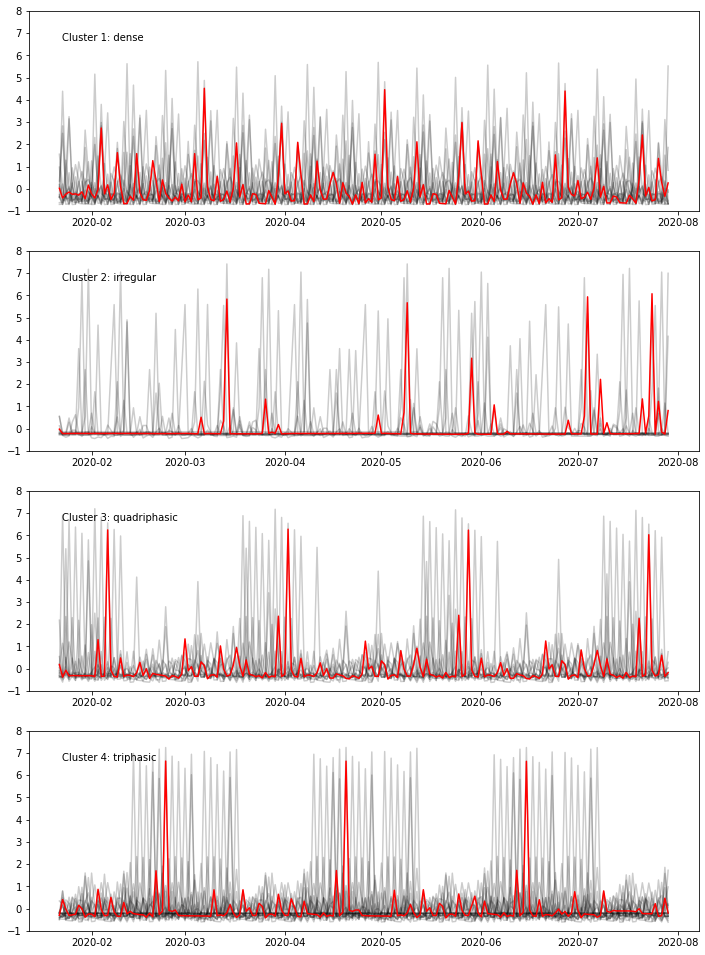

In [203]:
plot_data(scaled_data, y_p, sdtw_kmeans)

### Create choropleth clustering map

US States shapefile extracted from [here](https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_state_5m.zip), courtesy of US Census Bureau.

In [287]:
import geopandas as gpd

In [288]:
map_df = gpd.read_file("cb_2019_us_state_5m.shp")[["STUSPS", "geometry"]]
map_df.index = map_df.STUSPS
map_df = map_df[["geometry"]]

In [289]:
cluster_df = pd.DataFrame([y_p, scaled_data.columns]).T
cluster_df.columns = ["cluster", "STUSPS"]
cluster_df.cluster = cluster_df.cluster + 1
cluster_df.index = cluster_df.STUSPS
cluster_df = cluster_df[["cluster"]]

In [290]:
map_df = map_df.join(cluster_df)

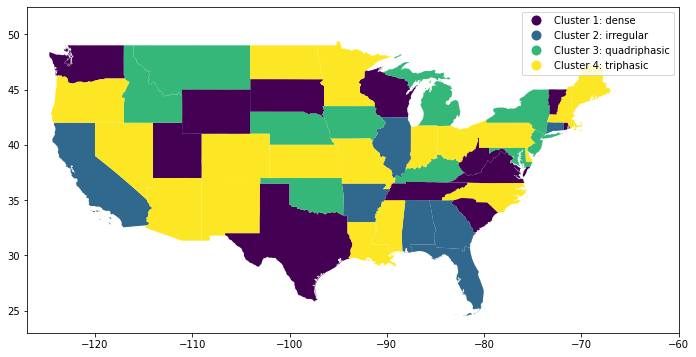

In [325]:
def plot_map_with_clusters(map_df, save=True):
    fig, ax = plt.subplots(1, figsize=(15, 6))
    map_df.plot(column="cluster", cmap="viridis", ax=ax, k=4, legend=True, linewidth=10)
    ax.set_ylim(23, 52.5)
    ax.set_xlim(-127, -60)

    leg = ax.get_legend()
    leg.get_texts()[0].set_text("Cluster 1: dense")
    leg.get_texts()[1].set_text("Cluster 2: irregular")
    leg.get_texts()[2].set_text("Cluster 3: quadriphasic")
    leg.get_texts()[3].set_text("Cluster 4: triphasic")
    
    if save:
        